# Set up dependencies

In [35]:
#Importing libraries
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout 
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import classification_report,precision_recall_curve, roc_curve, accuracy_score, confusion_matrix, precision_score, recall_score

import tensorflow as tf

import cv2
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load data

In [2]:
#mount google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
#Giving path of training and Testing data
train_path = '/content/drive/MyDrive/ML/xray/data/chest_xray/train'
val_path = '/content/drive/MyDrive/ML/xray/data/chest_xray/val'
test_path = '/content/drive/MyDrive/ML/xray/data/chest_xray/test'

In [4]:
# Simple function to performing pre-processing (resizing and converting image formats)
labels = ['NORMAL', 'PNEUMONIA']
img_size = 224
def get_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)#convert BGR to RGB format
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [5]:
#Grab the data 
train = get_data(train_path)
val = get_data(val_path)
test = get_data(test_path)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  app.launch_new_instance()




```
# This is formatted as code
```

# Visualise data

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


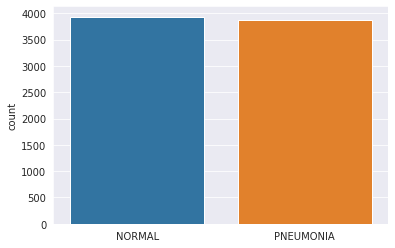

In [6]:
#Looking at target class counts
import seaborn as sns
l = []
for i in train:
    if(i[1] == 0):
        l.append("NORMAL")
    else:
        l.append("PNEUMONIA")
sns.set_style('darkgrid')
sns.countplot(l)
plt.savefig('training_data.png')

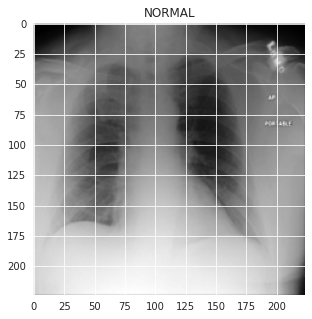

In [7]:
#PLotting some normal images
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize = (5,5))
plt.imshow(train[1][0], cmap='gray')
plt.title(labels[train[0][1]])
plt.savefig('Normal.png')

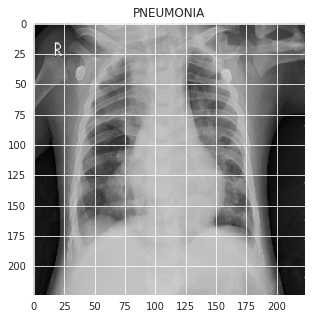

In [8]:
#PLotting some penumonia Images

plt.figure(figsize = (5,5))
plt.imshow(train[-1][0], cmap='gray')
plt.title(labels[train[-1][1]])
plt.savefig('Pneumonia.png')



```
# This is formatted as code
```

# Data processing

In [9]:
#Segregrating data into training, test data sets
x_train = []
y_train = []
x_val = []
y_val = []
x_test = []
y_test = []

for feature, labels in train:
  x_train.append(feature)
  y_train.append(labels)

for feature, labels in val:
  x_val.append(feature)
  y_val.append(labels)

for feature, labels in test:
  x_test.append(feature)
  y_test.append(labels)

In [10]:
# Normalize the data
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255
x_test = np.array(x_test) / 255

x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

In [11]:
print(x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape)

(7811, 224, 224) (7811,) (16, 224, 224) (16,) (624, 224, 224) (624,)


In [12]:
#More preprocessing
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train.reshape(7811, 224, 224, 1))

In [13]:
x_train=x_train.reshape(7811, 224, 224, 1)
x_val = x_val.reshape(16, 224, 224, 1)
x_test = x_test.reshape(624, 224, 224, 1)

In [14]:
print(x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape)

(7811, 224, 224, 1) (7811,) (16, 224, 224, 1) (16,) (624, 224, 224, 1) (624,)


# Model parameters

In [15]:
#CNN layers
model = Sequential()
model.add(Conv2D(32,3,padding="same", activation="relu", input_shape=(img_size,img_size,1)))
model.add(MaxPool2D())

model.add(Conv2D(32, 3, padding="same", activation="relu"))
model.add(MaxPool2D())

model.add(Conv2D(64, 3, padding="same", activation="relu"))
model.add(MaxPool2D())
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(128,activation="relu"))
model.add(Dense(2, activation="softmax"))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 28, 28, 64)       0

In [16]:
print(x_train.shape, y_train.shape, x_val.shape, y_val.shape)

(7811, 224, 224, 1) (7811,) (16, 224, 224, 1) (16,)


In [17]:
x_train.dtype

dtype('float64')

In [18]:
#Hyperparameter Tuning (Setting Adam optimizer)
opt = Adam(lr=0.000001)
model.compile(optimizer = opt , loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True) , metrics = ['accuracy'])


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


# Execute the model

In [19]:
#Hyperparameter Tuning (Setting Number of epoch optimizer)

history = model.fit( x_train, y_train, epochs = 5, validation_data = (x_val, y_val))


Epoch 1/5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


245/245 [==============================] - 20s 39ms/step - loss: 0.6827 - accuracy: 0.6189 - val_loss: 0.6841 - val_accuracy: 0.6250
Epoch 2/5
245/245 [==============================] - 9s 37ms/step - loss: 0.6564 - accuracy: 0.7463 - val_loss: 0.6722 - val_accuracy: 0.5625
Epoch 3/5
245/245 [==============================] - 9s 37ms/step - loss: 0.6190 - accuracy: 0.8108 - val_loss: 0.6533 - val_accuracy: 0.5625
Epoch 4/5
245/245 [==============================] - 9s 37ms/step - loss: 0.5759 - accuracy: 0.8419 - val_loss: 0.6342 - val_accuracy: 0.6250
Epoch 5/5
245/245 [==============================] - 9s 37ms/step - loss: 0.5285 - accuracy: 0.8634 - val_loss: 0.6191 - val_accuracy: 0.6250


In [20]:
#save the model
model.save('/content/drive/MyDrive/ML/xray/Model/CNN_Xray_v31.h5')

In [21]:
# model1 = tf.keras.models.load_model("/content/drive/MyDrive/ML/xray/Model/CNN_Xray_v30.h5")

In [22]:
#Hyperparameter Tuning (Setting Number of epoch optimizer)

# history = model1.fit(x_train,y_train,epochs = 5, validation_data = (x_val, y_val))

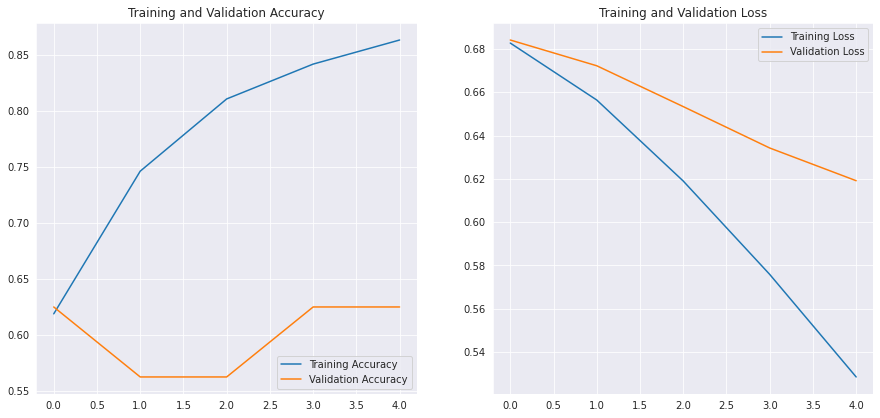

<Figure size 432x288 with 0 Axes>

In [23]:
#visualise training output
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(5)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
plt.savefig('Train_Val_Acc_Loss.png')

# Performance metrics

In [26]:
#Predicting the  0 for Normal
#'Normal (Class 0)','Pneumonia (Class 1)'
predictions = np.argmax(model.predict(x_val),axis=1)
predictions[1]

1

In [27]:
#Calculate precision and recall
predictions = np.argmax(model.predict(x_val),axis=1)

predictions = predictions.reshape(1,-1)[0]
print(classification_report(y_val, predictions, target_names = ['Normal (Class 0)','Pneumonia (Class 1)']))

                     precision    recall  f1-score   support

   Normal (Class 0)       1.00      0.25      0.40         8
Pneumonia (Class 1)       0.57      1.00      0.73         8

           accuracy                           0.62        16
          macro avg       0.79      0.62      0.56        16
       weighted avg       0.79      0.62      0.56        16



# Performance on test data

In [29]:
#Calculate precision and recall
predictions = np.argmax(model.predict(x_test),axis=1)

predictions = predictions.reshape(1,-1)[0]
print(classification_report(y_test, predictions, target_names = ['Normal (Class 0)','Pneumonia (Class 1)']))

                     precision    recall  f1-score   support

   Normal (Class 0)       0.90      0.65      0.75       234
Pneumonia (Class 1)       0.82      0.96      0.88       390

           accuracy                           0.84       624
          macro avg       0.86      0.80      0.82       624
       weighted avg       0.85      0.84      0.83       624



In [32]:
#Accuracy on test data
test_loss, test_score = model.evaluate(x_test, y_test, batch_size=20)
print("Loss on test set: ", test_loss)
print("Accuracy on test set: ", test_score)

32/32 [==============================] - 1s 14ms/step - loss: 0.5247 - accuracy: 0.8413
Loss on test set:  0.5246770977973938
Accuracy on test set:  0.8413461446762085


In [33]:
#Calculate confusion matrix
cm = confusion_matrix(y_test,predictions)
cm

array([[151,  83],
       [ 16, 374]])

In [36]:
#create cm df
cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])

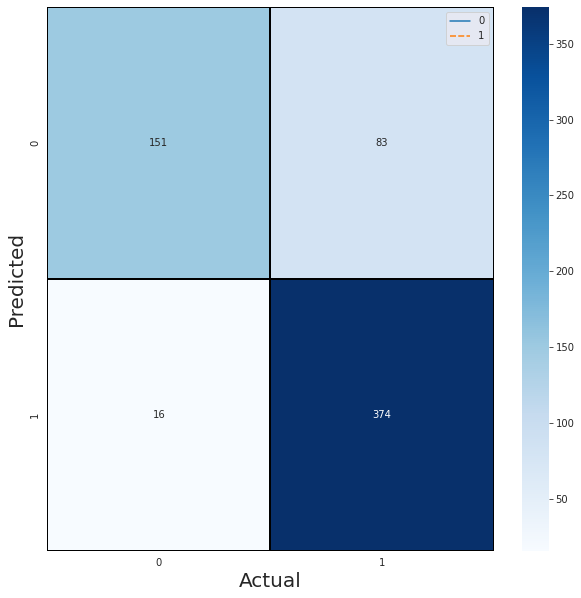

In [41]:
#create confusion matrix heatmap
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = labels,yticklabels = labels)
p = sns.lineplot(data =cm)
p.set_xlabel("Actual", fontsize = 20)
p.set_ylabel("Predicted", fontsize = 20)
plt.savefig('confusion matrix.png')